In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from bliss.datasets.pair_sim import generate_pair_dataset

from bliss.datasets.lsst import prepare_final_galaxy_catalog, get_default_lsst_psf
from bliss.reporting import get_residual_measurements, get_deblended_reconstructions

import matplotlib.pyplot as plt
from bliss.catalog import FullCatalog, TileCatalog, turn_samples_into_catalogs
import pytorch_lightning as pl

import torch
import numpy as np 

from tqdm import tqdm

# Loading and organizing

In [ ]:
import torch
import matplotlib.pyplot as plt
from bliss.datasets.lsst import APERTURE_BACKGROUND

In [ ]:
ds =torch.load("../../figures/pair_sim/pair_sim_results_2.pt")

In [ ]:
ds.keys()

dict_keys(['outs', 'bld', 'true_snr', 'true_flux', 'true_plocs', 'images'])

In [ ]:
ds['outs'][0].keys()

dict_keys(['nonzero_locs', 'sample_plocs', 'n_sources_samples', 'det_prob', 'sample_fluxes', 'idx', 'n_sources_map', 'map_flux', 'map_plocs'])

In [ ]:
print(len(ds['outs']))
print(ds['bld'].shape)

2000
torch.Size([2000, 2])


In [ ]:
# need to sort things first!!!!
sorted_indices = [out['idx'] for out in ds['outs']]
true_fluxes = ds['true_flux'][sorted_indices][:, 0, 0]
bld = ds['bld'][sorted_indices][:, 0].ravel()
true_snr = ds['true_snr'][sorted_indices][:, 0, 0]
true_fluxes.shape, bld.shape, true_snr.shape

(torch.Size([2000]), torch.Size([2000]), torch.Size([2000]))

In [ ]:
true_plocs = ds['true_plocs'][sorted_indices]
dist = torch.norm(true_plocs[:, 0, :] - true_plocs[:, 1, :], dim=-1)
dist.shape

torch.Size([2000])

In [ ]:
map_fluxes = torch.tensor([out['map_flux'] for out in ds['outs']])
map_fluxes.shape, true_fluxes.shape

(torch.Size([2000]), torch.Size([2000]))

In [ ]:
# randomly pick 100 samples
samples_fluxes = torch.stack([out['sample_fluxes'] for out in ds['outs']])[:, ::5]
samples_fluxes.shape


torch.Size([2000, 100])

# Histograms

(array([ 25.,  42.,  59.,  62.,  76.,  65.,  79.,  92.,  87.,  82.,  95.,
        102.,  93., 112.,  93.,  93., 115., 105., 125.,  84.,  62.,  63.,
         45.,  34.,  29.,  25.,  16.,  18.,  17.,   5.]),
 array([ 2.55690217,  2.81619406,  3.07548594,  3.33477783,  3.59406948,
         3.85336161,  4.11265326,  4.37194538,  4.63123703,  4.89052868,
         5.1498208 ,  5.40911293,  5.66840458,  5.92769623,  6.18698788,
         6.44628   ,  6.70557213,  6.96486378,  7.22415543,  7.48344707,
         7.74273968,  8.00203133,  8.26132298,  8.52061462,  8.77990627,
         9.03919888,  9.29849052,  9.55778217,  9.81707382, 10.07636642,
        10.33565807]),
 <BarContainer object of 30 artists>)

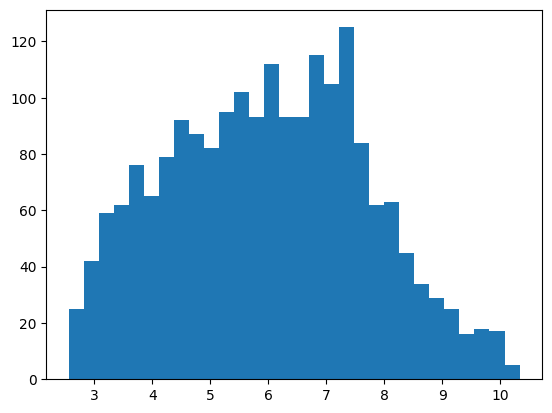

In [ ]:
true_plocs = ds['true_plocs']
dist = torch.norm(true_plocs[:, 0, :] - true_plocs[:, 1, :], dim=-1)
plt.hist(dist.numpy(), bins=30)

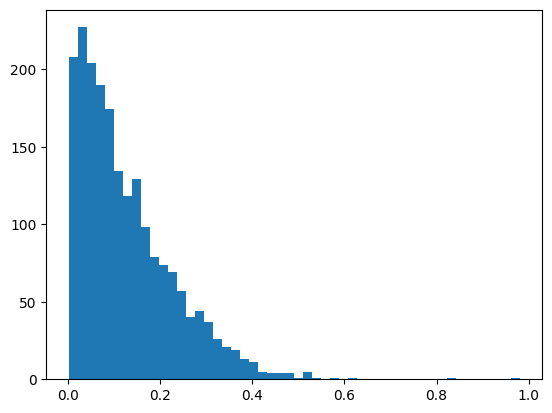

In [ ]:
plt.hist(ds['bld'][:, 0].ravel(), bins=50);

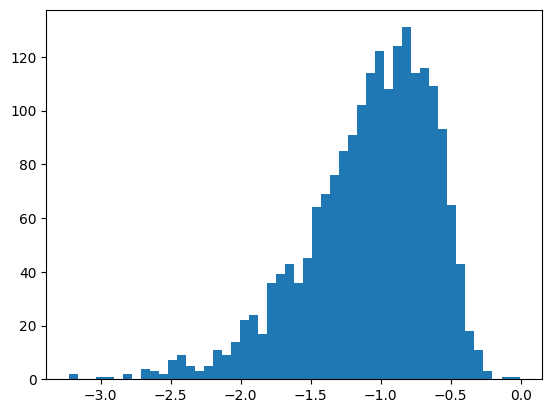

In [ ]:
plt.hist(ds['bld'][:, 0].ravel().log10(), bins=50);

(array([ 25.,  42.,  59.,  62.,  76.,  65.,  79.,  92.,  87.,  82.,  95.,
        102.,  93., 112.,  93.,  93., 115., 105., 125.,  84.,  62.,  63.,
         45.,  34.,  29.,  25.,  16.,  18.,  17.,   5.]),
 array([ 2.55690217,  2.81619406,  3.07548594,  3.33477783,  3.59406948,
         3.85336161,  4.11265326,  4.37194538,  4.63123703,  4.89052868,
         5.1498208 ,  5.40911293,  5.66840458,  5.92769623,  6.18698788,
         6.44628   ,  6.70557213,  6.96486378,  7.22415543,  7.48344707,
         7.74273968,  8.00203133,  8.26132298,  8.52061462,  8.77990627,
         9.03919888,  9.29849052,  9.55778217,  9.81707382, 10.07636642,
        10.33565807]),
 <BarContainer object of 30 artists>)

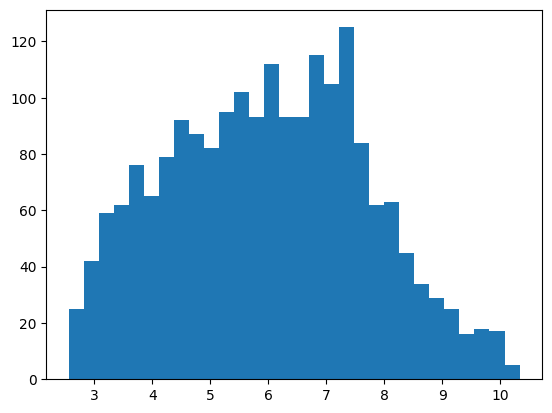

In [ ]:
# distance
true_plocs = ds['true_plocs'][sorted_indices]
dist = torch.norm(true_plocs[:, 0, :] - true_plocs[:, 1, :], dim=-1)
plt.hist(dist.numpy(), bins=30)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   7.,  10.,
         31.,  85., 124., 142., 161., 174., 155., 148., 128., 116.,  97.,
        106.,  84.,  72.,  62.,  49.,  51.,  31.,  29.,  28.,  16.,  18.,
         12.,  13.,  12.,   2.,  10.,   3.,   5.,   6.,   0.,   1.,   1.,
          2.,   1.,   0.,   0.,   0.,   1.]),
 array([0.15636297, 0.2350544 , 0.31374586, 0.39243728, 0.4711287 ,
        0.54982013, 0.62851161, 0.70720303, 0.78589445, 0.86458588,
        0.9432773 , 1.02196884, 1.1006602 , 1.17935169, 1.25804317,
        1.33673453, 1.41542602, 1.4941175 , 1.57280886, 1.65150034,
        1.73019171, 1.80888319, 1.88757467, 1.96626604, 2.0449574 ,
        2.12364888, 2.20234036, 2.28103185, 2.35972333, 2.43841481,
        2.51710606, 2.59579754, 2.67448902, 2.7531805 , 2.83187199,
        2.91056323, 2.98925471, 3.0679462 , 3.14663768, 3.22532916,
        3.3040204 , 3.38271189, 3.46140337, 3.54009485, 3.61878633,
        3.69747782, 3.77616906, 3.85486054, 3.

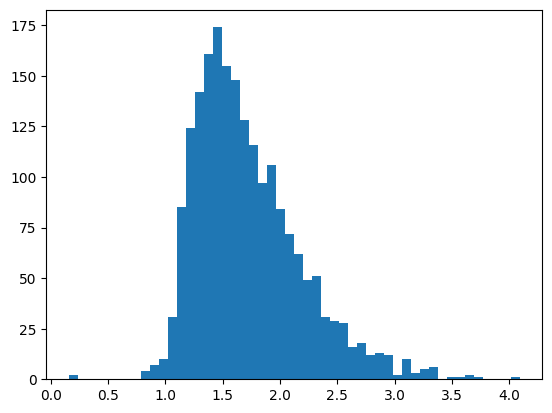

In [ ]:
# snr histogram
plt.hist(ds['true_snr'][:, 0, 0].ravel().log10(), bins=50)

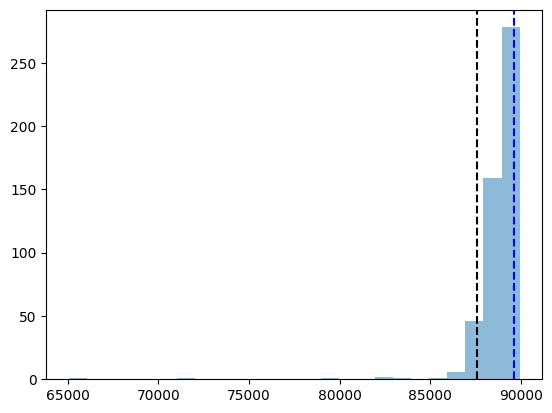

In [ ]:
# check one sample 
idx = 124
plt.hist(samples_fluxes[idx].numpy(), bins=25, alpha=0.5, label='Sample Fluxes')
plt.axvline(true_fluxes[idx].item(), color='k', linestyle='--', label='True Flux')
plt.axvline(map_fluxes[idx].item(), color='blue', linestyle='--', label='Map Flux')

# Preliminary results

In [ ]:
samples_fluxes.shape

torch.Size([2000, 100])

In [ ]:
res1 = (samples_fluxes.nanmean(dim=1) - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res2 = (map_fluxes - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res1.shape, res2.shape

(torch.Size([2000]), torch.Size([2000]))

In [ ]:
res1.nanmean(), res1[:10]

(tensor(0.1016),
 tensor([ 1.9267e-03, -7.9643e-03, -2.1085e-02, -2.7681e-05, -8.0233e-03,
         -2.5995e-03,  3.3131e-04, -1.2650e-02, -2.1697e-02, -3.7360e-02]))

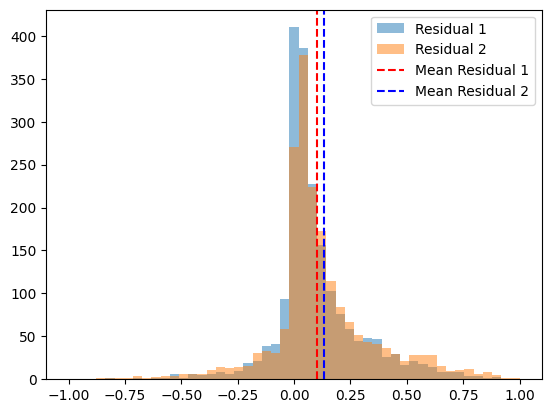

In [ ]:
bins = np.linspace(-1, 1, 50)

_ = plt.hist(res1, bins=bins, alpha=0.5, label='Residual 1')
plt.hist(res2, bins=bins, alpha=0.5, label='Residual 2')
plt.axvline(res1.nanmean().item(), color='red', linestyle='--', label='Mean Residual 1')
plt.axvline(res2.nanmean().item(), color='blue', linestyle='--', label='Mean Residual 2')
plt.legend()

In [ ]:
res1.nanmean(), res2.nanmean()

(tensor(0.1016), tensor(0.1323))

(-1.0, 1.0)

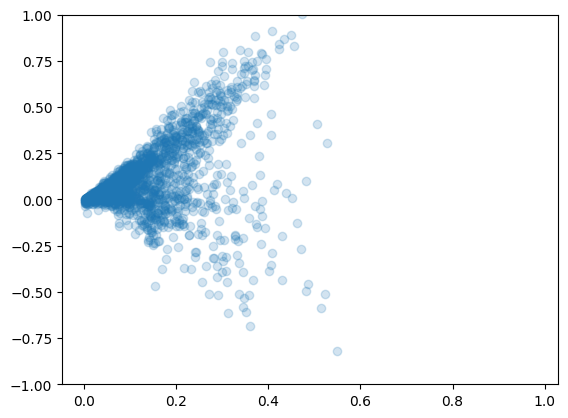

In [ ]:
# as a function of blendedness
plt.scatter(bld, res1, alpha=0.2, label='Residual 1')
# plt.scatter(ds['bld'][:, 0].ravel(), res2, alpha=0.2, label='Residual 2')
plt.ylim(-1, 1)

(-1.0, 1.0)

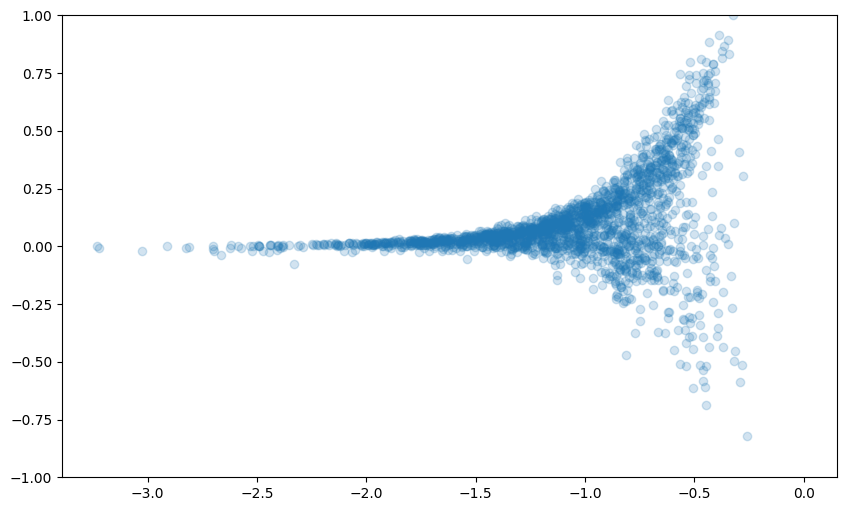

In [ ]:
# as a function of blendedness
plt.figure(figsize=(10, 6))
plt.scatter(bld.log10(), res1, alpha=0.2, label='Residual 1')
# plt.scatter(ds['bld'][:, 0].ravel(), res2, alpha=0.2, label='Residual 2')
plt.ylim(-1, 1)

(-1.0, 1.0)

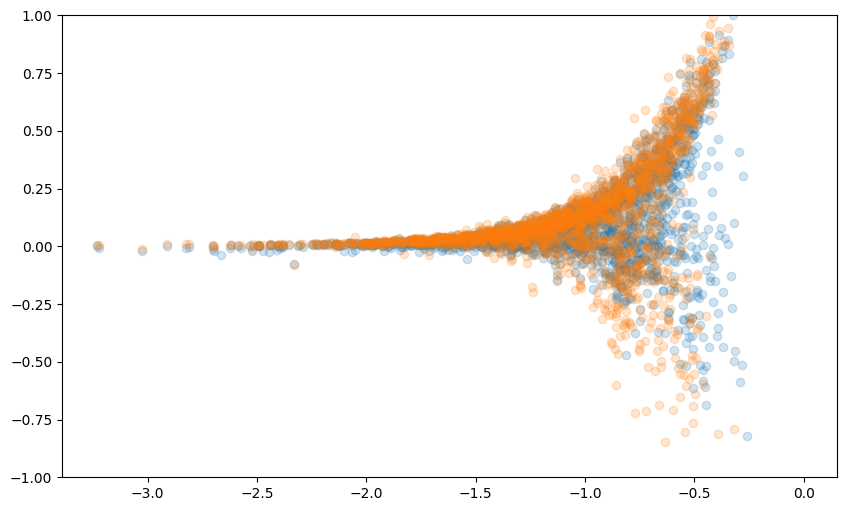

In [ ]:
# as a function of blendedness
plt.figure(figsize=(10, 6))
plt.scatter(bld.log10(), res1, alpha=0.2, label='Residual 1')
plt.scatter(bld.log10(), res2, alpha=0.2, label='Residual 2')
# plt.scatter(ds['bld'][:, 0].ravel(), res2, alpha=0.2, label='Residual 2')
plt.ylim(-1, 1)

(-1.0, 1.0)

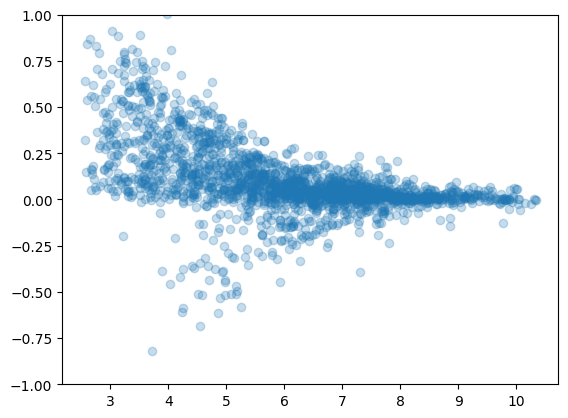

In [ ]:
# as a function of distance
plt.scatter(dist, res1, alpha=0.25, label='Residual 1')
# plt.scatter(dist, res2, alpha=0.25, label='Residual 2')
plt.ylim(-1, 1)

(-1.0, 1.0)

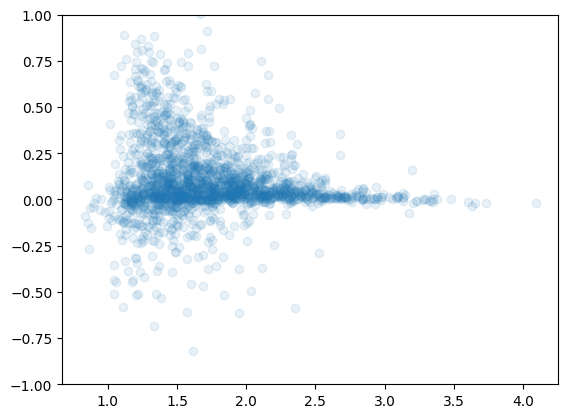

In [ ]:
# snr
plt.scatter(true_snr.log10(), res1, alpha=0.1, label='Residual 1')
plt.ylim(-1, 1)

In [ ]:
# ds['bld'][:, 0].ravel().log10().min()

In [ ]:
bld.shape

torch.Size([2000])

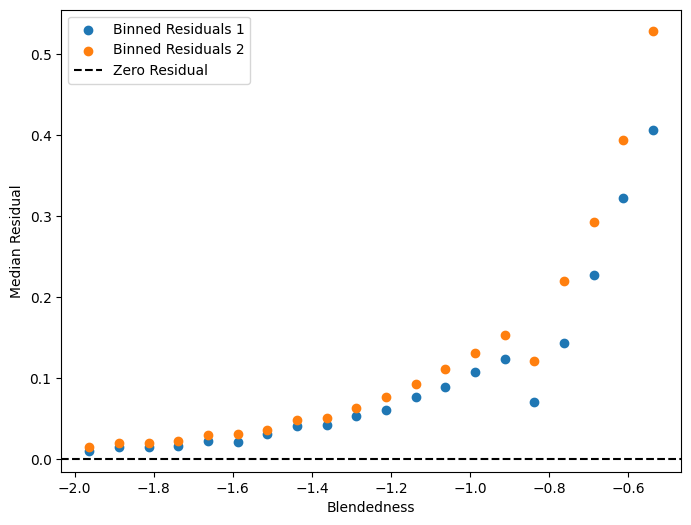

In [ ]:
# binned by blendedness
from scipy.stats import binned_statistic
log_bld = bld.log10()
binned_residuals, bin_edges, _ = binned_statistic(
    log_bld.numpy(),
    res1.numpy(),
    statistic='median',
    bins=20,
    range=(-2, -0.5)
)

binned_residuals2, bin_edges2, _ = binned_statistic(
    log_bld.numpy(),
    res2.numpy(),
    statistic='median',
    bins=20,
    range=(-2, -0.5)
)



plt.figure(figsize=(8, 6))
plt.scatter(
    (bin_edges[:-1] + bin_edges[1:]) / 2,
    binned_residuals,
    label='Binned Residuals 1',
)
plt.scatter(
    (bin_edges2[:-1] + bin_edges2[1:]) / 2,
    binned_residuals2,
    label='Binned Residuals 2',
)
plt.xlabel('Blendedness')
plt.ylabel('Median Residual')
plt.axhline(0, color='k', linestyle='--', label='Zero Residual')
plt.legend()

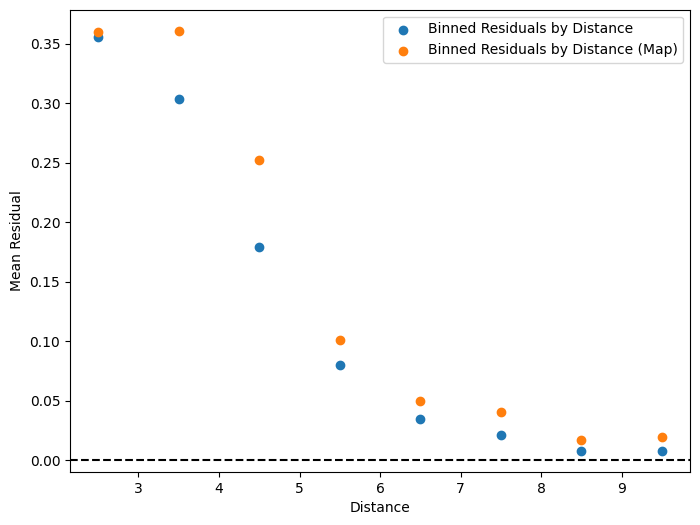

In [ ]:
# now binned by distance
binned_residuals_dist, bin_edges_dist, _ = binned_statistic(
    dist.numpy(),
    res1.numpy(),
    statistic='median',
    bins=10,
    range=(0, 10)
)
# map
binned_residuals_map, bin_edges_map, _ = binned_statistic(
    dist.numpy(),
    res2.numpy(),
    statistic='median',
    bins=10,
    range=(0, 10)
)

plt.figure(figsize=(8, 6))
plt.scatter(
    (bin_edges_dist[:-1] + bin_edges_dist[1:]) / 2,
    binned_residuals_dist,
    label='Binned Residuals by Distance',
    color='C0',
)
plt.scatter(
    (bin_edges_map[:-1] + bin_edges_map[1:]) / 2,
    binned_residuals_map,
    label='Binned Residuals by Distance (Map)',
    color='C1',
)
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Mean Residual')
plt.axhline(0, color='k', linestyle='--', label='Zero Residual')

In [ ]:
true_snr.shape

torch.Size([2000])

In [ ]:
true_snr.min()

tensor(-1.8525)

Text(0, 0.5, 'Mean Residual')

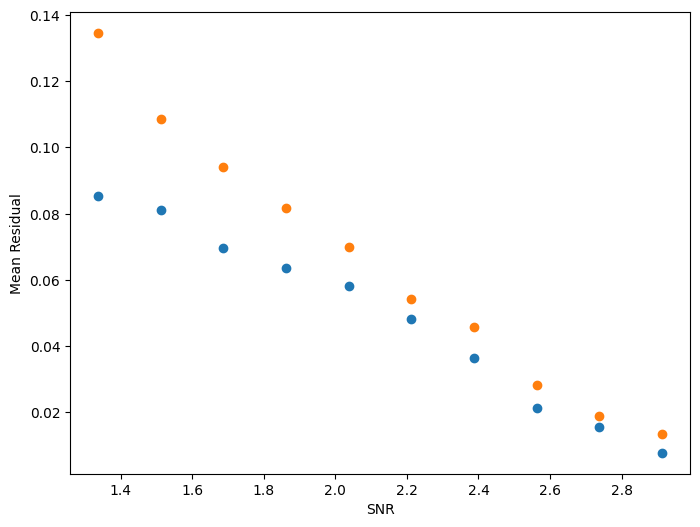

In [ ]:
# bin by snr
mask = ~torch.isnan(true_snr) & (true_snr > 0)
_log_snr = np.log10(true_snr[mask].numpy())
res1_masked = res1[mask].numpy()
res2_masked = res2[mask].numpy()


binned_residuals_snr, bin_edges_snr, _ = binned_statistic(
    _log_snr,
    res1_masked,
    statistic='median',
    bins=10,
    range=(1.25, 3)
)

binned_residuals_snr2, bin_edges_snr2, _ = binned_statistic(
    _log_snr,
    res2_masked,
    statistic='median',
    bins=10,
    range=(1.25, 3)
)

plt.figure(figsize=(8, 6))
plt.scatter(
    (bin_edges_snr[:-1] + bin_edges_snr[1:]) / 2,
    binned_residuals_snr,
    label='Binned Residuals by SNR',
)

plt.scatter(
    (bin_edges_snr2[:-1] + bin_edges_snr2[1:]) / 2,
    binned_residuals_snr2,
    label='Binned Residuals by SNR',
)

plt.xlabel('SNR')
plt.ylabel('Mean Residual')

# Standard deviation

In [ ]:
samples_fluxes.shape

torch.Size([2000, 100])

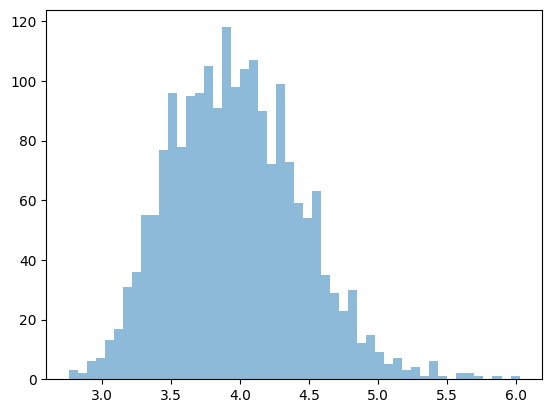

In [ ]:
# histogram standard deviation of samples
stds = [] 
for ii in range(len(samples_fluxes)):
    mask = ~torch.isnan(samples_fluxes[ii])
    if mask.sum() > 1:
        stds.append(torch.std(samples_fluxes[ii][mask]).item())
    else: 
        stds.append(torch.nan)
stds= torch.tensor(stds)
plt.hist(stds.log10(), bins=50, alpha=0.5, label='Standard Deviation of Sample Fluxes');

Text(0.5, 0, 'Z-score')

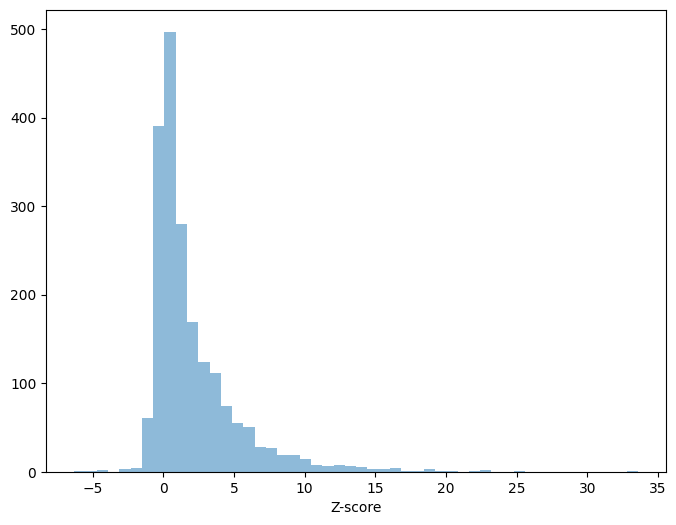

In [ ]:
# now divided by residuals
plt.figure(figsize=(8, 6))
z_score =  (samples_fluxes.nanmean(dim=1) - true_fluxes) / (stds + APERTURE_BACKGROUND)
plt.hist(
    z_score.numpy(),bins=50, alpha=0.5, label='Z-score of Sample Fluxes'
    );
plt.xlabel('Z-score')

Text(0, 0.5, 'Z-score')

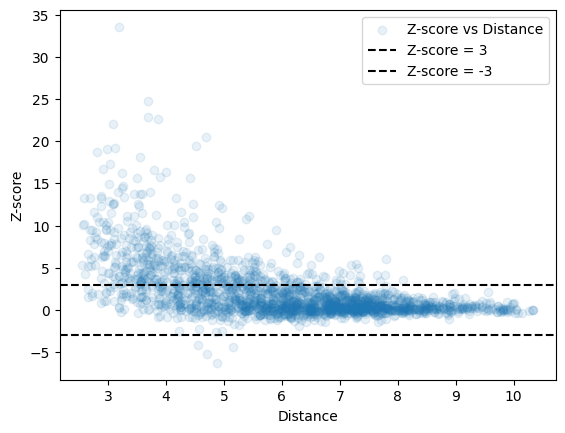

In [ ]:
plt.scatter(dist, z_score.numpy(), alpha=0.1, label='Z-score vs Distance')
plt.axhline(3, color='k', linestyle='--', label='Z-score = 3')
plt.axhline(-3, color='k', linestyle='--', label='Z-score = -3')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Z-score')

Text(0, 0.5, 'Z-score')

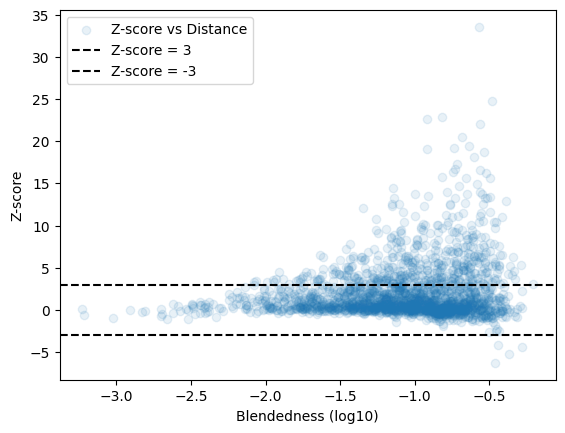

In [ ]:
plt.scatter(bld.log10(), z_score.numpy(), alpha=0.1, label='Z-score vs Distance')
plt.axhline(3, color='k', linestyle='--', label='Z-score = 3')
plt.axhline(-3, color='k', linestyle='--', label='Z-score = -3')
plt.legend()
plt.xlabel('Blendedness (log10)')
plt.ylabel('Z-score')

# Equally sized bins

In [ ]:
from bliss.plotting import equal_sized_bin_statistic
from bliss.datasets.lsst import APERTURE_BACKGROUND

In [ ]:
samples_fluxes.shape

torch.Size([2000, 100])

In [ ]:
res1 = (samples_fluxes.nanmean(dim=1) - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res2 = (map_fluxes - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res1.shape, res2.shape

(torch.Size([2000]), torch.Size([2000]))

In [ ]:
stds = [] 
for ii in range(len(samples_fluxes)):
    mask = ~torch.isnan(samples_fluxes[ii])
    if mask.sum() > 1:
        stds.append(torch.std(samples_fluxes[ii][mask]).item())
    else: 
        stds.append(torch.nan)
stds= torch.tensor(stds)
stds.shape

torch.Size([2000])

In [ ]:
z_score =  (samples_fluxes.nanmean(dim=1) - true_fluxes) / (stds + APERTURE_BACKGROUND)
z_score.shape

torch.Size([2000])

In [ ]:
mask_all = ~torch.isnan(true_snr) & (true_snr > 0) & ~torch.isnan(bld) & ~torch.isnan(res1) & ~torch.isnan(res2) & ~torch.isnan(z_score) & ~torch.isnan(stds)

res1 = res1[mask_all]
res2 = res2[mask_all]
z_score = z_score[mask_all]
bld = bld[mask_all]
true_snr = true_snr[mask_all]
stds = stds[mask_all]
dist = dist[mask_all]


In [ ]:
map_fluxes.isnan().sum(), stds.isnan().sum(), dist.isnan().sum(), true_fluxes.isnan().sum()

(tensor(23), tensor(0), tensor(0), tensor(0))

In [ ]:
res1.isnan().sum(), z_score.isnan().sum(), res2.isnan().sum()

(tensor(0), tensor(0), tensor(0))

In [ ]:
dist.min(), dist.max()

(tensor(2.5569), tensor(10.3357))

In [ ]:
# bin by bld
n_bins = 7
b_dict1 = equal_sized_bin_statistic(
    x=dist,
    y=res1,
    n_bins=n_bins,
    xlims=(2.5, 10), 
    statistic='median'
)

b_dict2 = equal_sized_bin_statistic(
    x=dist,
    y=res2,
    n_bins=n_bins,
    xlims=(2.5, 10), 
    statistic='median'
)

In [ ]:
b_dict1['middles'], b_dict1['stats'], b_dict1['errs'], b_dict1['counts']

(tensor([3.2360, 4.3816, 5.2490, 6.0109, 6.7271, 7.4449, 8.8987]),
 tensor([0.3069, 0.1914, 0.1132, 0.0463, 0.0269, 0.0221, 0.0081]),
 tensor([0.0212, 0.0174, 0.0098, 0.0042, 0.0039, 0.0018, 0.0013]),
 tensor([280, 279, 279, 280, 279, 279, 279], dtype=torch.int32))

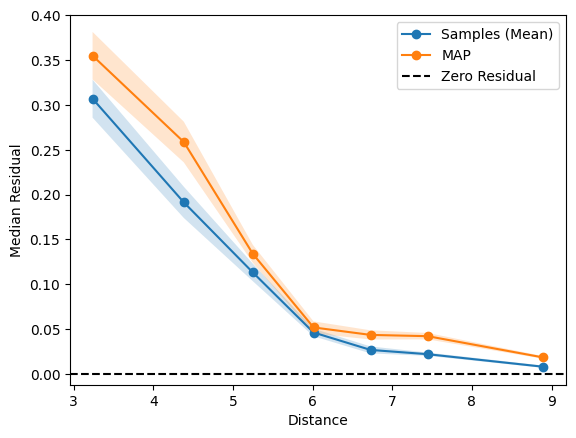

In [ ]:
plt.plot(b_dict1['middles'], b_dict1['stats'], label='Samples (Mean)', marker='o')
plt.fill_between(
    b_dict1['middles'],
    b_dict1['stats'] - b_dict1['errs'],
    b_dict1['stats'] + b_dict1['errs'],
    alpha=0.2,
)


plt.plot(b_dict2['middles'], b_dict2['stats'], label='MAP', marker='o')
plt.fill_between(
    b_dict2['middles'],
    b_dict2['stats'] - b_dict2['errs'],
    b_dict2['stats'] + b_dict2['errs'],
    alpha=0.2,
)
plt.xlabel('Distance')
plt.ylabel('Median Residual')
plt.axhline(0, color='k', linestyle='--', label='Zero Residual')
plt.legend()

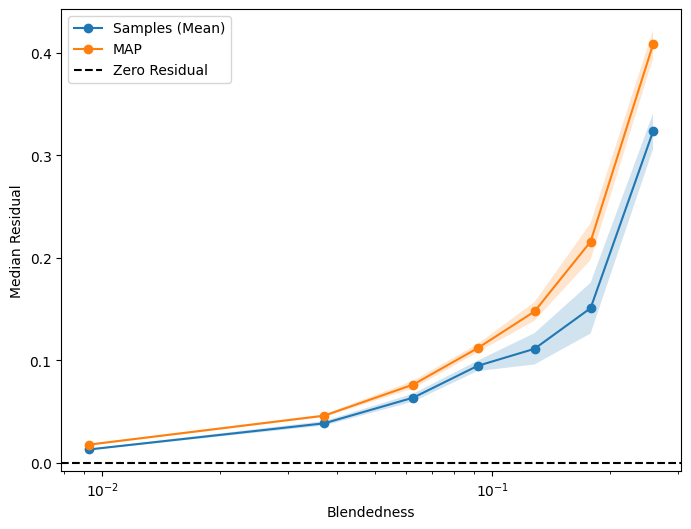

In [ ]:
# same but blendedness (log space)
n_bins = 7
b_dict1_bld = equal_sized_bin_statistic(
    x=bld.log10(),
    y=res1,
    n_bins=n_bins,
    xlims=(-2.5, -0.5), 
    statistic='median'
)
b_dict2_bld = equal_sized_bin_statistic(
    x=bld.log10(),
    y=res2,
    n_bins=n_bins,
    xlims=(-2.5, -0.5), 
    statistic='median'
)
plt.figure(figsize=(8, 6))
assert torch.all(b_dict1_bld['middles'] == b_dict2_bld['middles'])

x = 10**b_dict1_bld['middles']

plt.plot(x, b_dict1_bld['stats'], label='Samples (Mean)', marker='o')
plt.fill_between(
    x,
    b_dict1_bld['stats'] - b_dict1_bld['errs'],
    b_dict1_bld['stats'] + b_dict1_bld['errs'],
    alpha=0.2,
)
plt.plot(x, b_dict2_bld['stats'], label='MAP', marker='o')
plt.fill_between(
    x,
    b_dict2_bld['stats'] - b_dict2_bld['errs'],
    b_dict2_bld['stats'] + b_dict2_bld['errs'],
    alpha=0.2,
)
plt.xlabel('Blendedness')
plt.ylabel('Median Residual')
plt.axhline(0, color='k', linestyle='--', label='Zero Residual')
plt.xscale('log')
plt.legend()

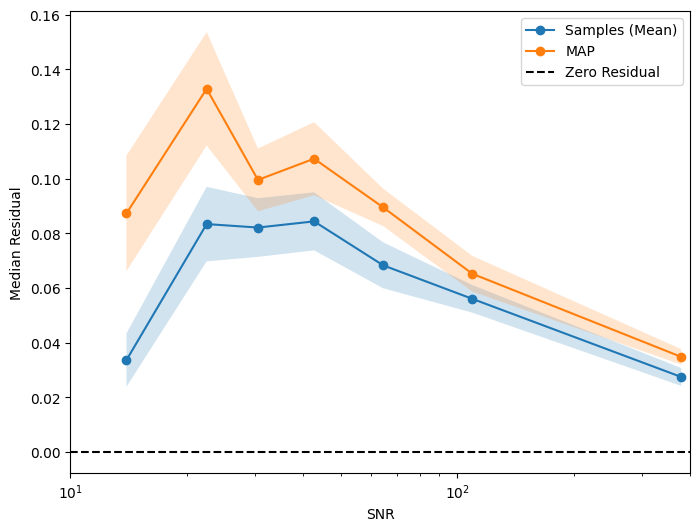

In [ ]:
# now snr 
n_bins = 7
b_dict1_snr = equal_sized_bin_statistic(
    x=true_snr.log10(),
    y=res1,
    n_bins=n_bins,
    xlims=(1.0, 3), 
    statistic='median'
)
b_dict2_snr = equal_sized_bin_statistic(
    x=true_snr.log10(),
    y=res2,
    n_bins=n_bins,
    xlims=(1.0, 3), 
    statistic='median'
)
assert torch.all(b_dict1_snr['middles'] == b_dict2_snr['middles'])
x = 10**b_dict1_snr['middles']


plt.figure(figsize=(8, 6))
plt.plot(x, b_dict1_snr['stats'], label='Samples (Mean)', marker='o')
plt.fill_between(
   x,
    b_dict1_snr['stats'] - b_dict1_snr['errs'],
    b_dict1_snr['stats'] + b_dict1_snr['errs'],
    alpha=0.2,
)
plt.plot(x, b_dict2_snr['stats'], label='MAP', marker='o')
plt.fill_between(
    x,
    b_dict2_snr['stats'] - b_dict2_snr['errs'],
    b_dict2_snr['stats'] + b_dict2_snr['errs'],
    alpha=0.2,
)
plt.xlabel('SNR')
plt.ylabel('Median Residual')
plt.axhline(0, color='k', linestyle='--', label='Zero Residual')
plt.legend()
plt.xlim(10, 400)
plt.xscale('log')